# Working with time series, frequency series, and unit conversion

In this notebook, we show some of the most useful features of the [timeseries](../series.rst) module. To do so, we will analyze a fake gravitational-wave signal. We will also show the [frequencyseries](../series.rst) module and the [unitconv](../unitconv.rst) modules.

First, let's generate this signal. 

(This notebook is meant to be converted in Sphinx documentation and not used directly.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from kuibit import timeseries as ts
from kuibit import series
from kuibit import unitconv as uc
from kuibit.gw_utils import luminosity_distance_to_redshift

%matplotlib inline

In [2]:
t = np.linspace(0, 20, 5000)
y = np.sin(t)

# Generate a TimeSeries by providing the times and the values of the series
gw = ts.TimeSeries(t, y)

To access the times and the values, use ``gw.t`` and ``gw.y``. You can also iterate over the series with a for loop yielding the elements `(t, y)` at each iteration of the loop. For example.

In [3]:
for tt, yy in gw:
    print(tt, yy)

0.0 0.0
0.004000800160032006 0.004000789486971321
0.008001600320064013 0.008001514935783532
0.012002400480096018 0.012002112309302542
0.016003200640128026 0.016002517572444287
0.020004000800160033 0.020002666693199687
0.024004800960192037 0.024002495643659576
0.028005601120224044 0.028001940401039562
0.03200640128025605 0.03200093694870479
0.03600720144028806 0.03599942127719461
0.040008001600320066 0.03999732938524717
0.04400880176035207 0.0439945972808238
0.048009601920384073 0.04799116098213332
0.05201040208041608 0.05198695651865616
0.05601120224044809 0.055981919932168285
0.060012002400480095 0.059975987277764924
0.0640128025605121 0.06396909462488413
0.0680136027205441 0.06796117805833003
0.07201440288057612 0.07195217367929596
0.07601520304060812 0.07594201760638712
0.08001600320064013 0.07993064597664322
0.08401680336067213 0.08391799494656059
0.08801760352070415 0.08790400069311417
0.09201840368073615 0.09188859941477902
0.09601920384076815 0.09587172733255157
0.10002000400080

0.016966914437553143
3.128625725145029 0.012966565068595825
3.132626525305061 0.008966008151863332
3.136627325465093 0.004965307721792166
3.140628125625125 0.0009645278151159581
3.144628925785157 -0.0030362675301595296
3.148629725945189 -0.007037014275781417
3.152630526105221 -0.011037648384274729
3.156631326265253 -0.015038105819967403
3.160632126425285 -0.01903832255001527
3.164632926585317 -0.023038234545426983
3.168633726745349 -0.0270377777820889
3.172634526905381 -0.031036888241789864
3.176635327065413 -0.03503550191324592
3.180636127225445 -0.03903355479312489
3.184636927385477 -0.04303098288707083
3.188637727545509 -0.04702772221072838
3.192638527705541 -0.05102370879076688
3.196639327865573 -0.05501887866590437
3.200640128025605 -0.05901316788793139
3.204640928185637 -0.06300651252273455
3.208641728345669 -0.06699884865131989
3.212642528505701 -0.07099011237083594
3.216643328665733 -0.07498023979559668
3.2206441288257652 -0.078969167058104
3.2246449289857972 -0.082956830310070

-0.2705684596696734
6.013202640528106 -0.2667147312719234
6.017203440688138 -0.26285673373668095
6.02120424084817 -0.2589945288165229
6.025205041008202 -0.2551281783313711
6.029205841168234 -0.2512577441675027
6.033206641328266 -0.24738328827655995
6.037207441488298 -0.24350487267455836
6.04120824164833 -0.2396225594408941
6.045209041808362 -0.23573641071735024
6.049209841968394 -0.2318464887071022
6.053210642128426 -0.22795285567372206
6.057211442288458 -0.22405557394018197
6.06121224244849 -0.22015470588785654
6.065213042608522 -0.21625031395552435
6.069213842768554 -0.2123424606383686
6.073214642928586 -0.20843120848697666
6.077215443088618 -0.204516620106339
6.08121624324865 -0.200598758154847
6.085217043408682 -0.1966776853432901
6.089217843568714 -0.19275346443385194
6.093218643728746 -0.18882615823910584
6.097219443888778 -0.18489582962100937
6.10122024404881 -0.18096254148989815
6.105221044208842 -0.17702635680347892
6.109221844368874 -0.17308733856582173
6.113222644528906 -0.1

9.253850770154031 0.17009610116103
9.257851570314063 0.1661522519514067
9.261852370474095 0.1622057432456061
9.265853170634127 0.15825663821294847
9.26985397079416 0.15430500006431183
9.273854770954191 0.1503508920511203
9.277855571114223 0.14639437746433154
9.281856371274255 0.14243551963342377
9.285857171434287 0.13847438192538203
9.28985797159432 0.13451102774368398
9.293858771754351 0.130545520527285
9.297859571914383 0.12657792374960272
9.301860372074415 0.12260830091750115
9.305861172234447 0.11863671557027403
9.30986197239448 0.1146632312786279
9.313862772554511 0.11068791164366452
9.317863572714543 0.10671082029586287
9.321864372874575 0.10273202089406061
9.325865173034607 0.09875157712443519
9.32986597319464 0.09476955269948442
9.333866773354671 0.09078601135700667
9.337867573514703 0.0868010168590807
9.341868373674735 0.08281463299104502
9.345869173834767 0.0788269235604769
9.3498699739948 0.07483795239617111
9.353870774154831 0.07084778334711817
9.357871574314863 0.066856480


12.090418083616724 -0.4581853182322846
12.094418883776756 -0.4546255227899245
12.098419683936788 -0.45105845043842985
12.10242048409682 -0.44748415827371807
12.106421284256852 -0.44390270350726985
12.110422084416884 -0.4403141434652132
12.114422884576916 -0.4367185355874058
12.118423684736948 -0.43311593742651583
12.12242448489698 -0.4295064066471004
12.126425285057012 -0.4258900010246829
12.130426085217044 -0.42226677844482796
12.134426885377076 -0.4186367969022151
12.138427685537108 -0.4150001144997104
12.14242848569714 -0.41135678944743637
12.146429285857172 -0.40770688006184036
12.150430086017204 -0.404050444764761
12.154430886177236 -0.4003875420824932
12.158431686337268 -0.39671823064485134
12.1624324864973 -0.39304256918423064
12.166433286657332 -0.38936061653466736
12.170434086817364 -0.38567243163089676
12.174434886977396 -0.3819780735074101
12.178435687137428 -0.3782776012975094
12.18243648729746 -0.37457107423236125
12.186437287457492 -0.3708585516400484
12.190438087617524 


14.486897379475895 0.939465110825626
14.490898179635927 0.9380867432896871
14.494898979795959 0.9366933603803274
14.498899779955991 0.9352849844005638
14.502900580116023 0.9338616378933985
14.506901380276055 0.9324233436414572
14.510902180436087 0.9309701246666251
14.51490298059612 0.9295020042296782
14.518903780756151 0.9280190058299109
14.522904580916183 0.92652115320476
14.526905381076215 0.9250084703294247
14.530906181236247 0.9234809814164827
14.53490698139628 0.9219387109155028
14.538907781556311 0.9203816835126537
14.542908581716343 0.9188099241303086
14.546909381876375 0.9172234579266463
14.550910182036407 0.9156223102952484
14.55491098219644 0.9140065068646936
14.558911782356471 0.9123760734981463
14.562912582516503 0.9107310362929435
14.566913382676535 0.9090714215801768
14.570914182836567 0.9073972559242709
14.5749149829966 0.9057085661225585
14.578915783156631 0.9040053792048509
14.582916583316663 0.9022877224330065
14.586917383476695 0.900555623300493
14.590918183636727 0

17.439487897579514 -0.9871109896592222
17.443488697739546 -0.9864628146159733
17.44748949789958 -0.9857988498734954
17.45149029805961 -0.9851191060594608
17.455491098219643 -0.9844235940541078
17.459491898379675 -0.9837123249900662
17.463492698539707 -0.9829853102521793
17.46749349869974 -0.9822425614773216
17.47149429885977 -0.9814840905542127
17.475495099019803 -0.9807099096232269
17.479495899179835 -0.9799200310761988
17.483496699339867 -0.9791144675562251
17.4874974994999 -0.9782932319574619
17.49149829965993 -0.9774563374249189
17.495499099819963 -0.9766037973542483
17.499499899979995 -0.975735625391531
17.503500700140027 -0.974851835433058
17.50750150030006 -0.9739524416251075
17.51150230046009 -0.9730374583637192
17.515503100620123 -0.9721069002944633
17.519503900780155 -0.9711607823122065
17.523504700940187 -0.9701991195608732
17.52750550110022 -0.9692219274332035
17.53150630126025 -0.9682292215705063
17.535507101420283 -0.9672210178624097
17.539507901580315 -0.9661973324466056

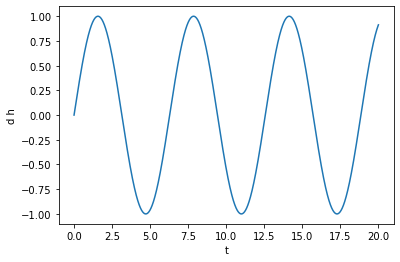

In [4]:
def plot(ser, lab1="d h", lab2="t", *args, **kwargs):
    """Plot Series ser with labels"""
    plt.ylabel(lab1)
    plt.xlabel(lab2)
    plt.plot(ser, *args, **kwargs)
    
plot(gw)

Let's make this more interesting: we square the signal and add Gaussian noise. [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) support directly using all the basic mathematical operations in Python and NumPy, so we can easily square the signal and add another TimeSeries to it.

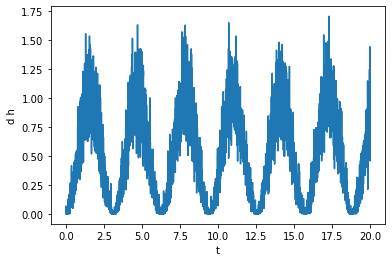

In [5]:
noise = np.random.normal(0, 0.1, len(gw))  # Here we used len() on the TimeSeries
noise_ts = ts.TimeSeries(t, noise)

gw += noise_ts
gw **= 2

plot(gw)

To analyze this signal, first we will smooth it. To do that, we will use the [savgol_smooth_time](../timeseries_ref.html#kuibit.timeseries.TimeSeries.savgol_smooth_time) method, which is a generalized "running average" filter. This method requires length of time over which we want to smooth the data.

In [TimeSeries](../timeseries_ref.html#kuibit.timeseries.TimeSeries) there are always two different methods to do the same task, one with imperative verb (e.g., smooth), and the other with the past tense (e.g., smoothed). The first modifies the data, the second returns a new `TimeSeries` with the operation applied. Here, we will find what smoothing length to use by trial and error, so we will use the second method. 

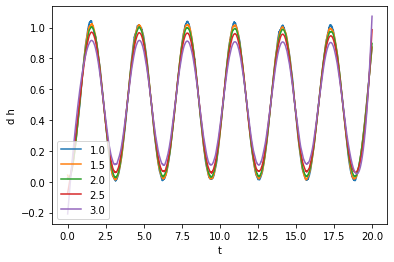

In [6]:
tsmooth = np.linspace(1, 3, 5)

for tsm in tsmooth:
    smoothed = gw.savgol_smoothed_time(tsm)
    plot(smoothed, label=tsm)
plt.legend()

From visual inspection it looks like that ``tsmooth = 1.5`` will work yield a clean series faithful to the original one.

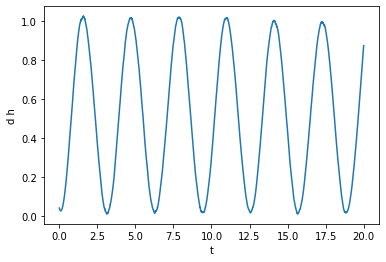

In [7]:
gw.savgol_smooth_time(1.5)
plot(gw)

Next, for fun, we can compute integrals and derivatives. For instance, we can compute what is the integral from 5 to 10.

The integral from 5 to 10 is 2.1978


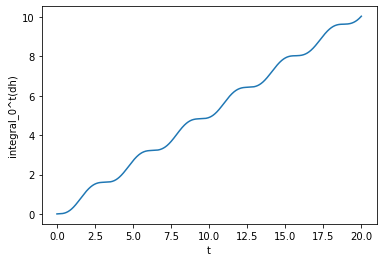

In [8]:
gw_int = gw.integrated()
a = 5
b = 10
print(f"The integral from {a} to {b} is {gw_int(b) - gw_int(a):.4f}")
plot(gw_int, lab1="integral_0^t(dh)")

Here, we showed a very powerful feature of `TimeSeries`: you can call them on a specific time (as we did we ``gw_int(b)``). This is done using splines to interpolate to the points that are not available. Splines can also be used to take derivatives. Alternatively, one can simply take the finite (central) difference. Let's see what's the derivative of ``gw`` using splines and finite difference.

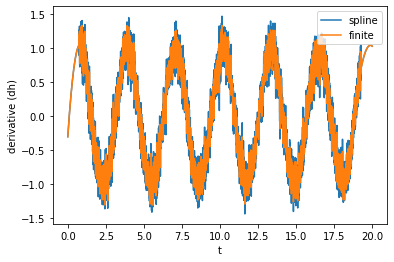

In [9]:
gw_spline_der = gw.spline_differentiated()
gw_numer_der = gw.differentiated()

plot(gw_spline_der, label='spline')
plot(gw_numer_der, lab1="derivative (dh)", label='finite')
plt.legend()

Clearly, derivatives will be noisier than the actual data, so often it is convenient to smooth them out as shown before.

TimeSeries support complex signals. Now, we will create one using `gw` itself. We will copy `gw`, time-shift it, find the common time interval with the original `gw`, and use that as a the imaginary part.

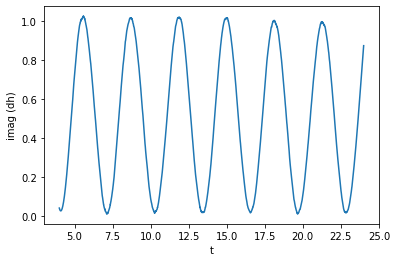

In [10]:
gw_imag = gw.copy()  # It is important to deep copy the object
gw_imag.time_shift(4)

plot(gw_imag, lab1 ="imag (dh)")

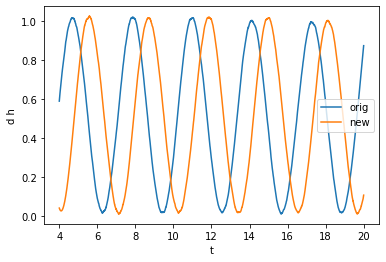

In [11]:
gw, gw_imag = series.sample_common([gw, gw_imag], resample=True)  # Resampling to common times

plot(gw, label="orig")
plot(gw_imag, label="new")
plt.legend()

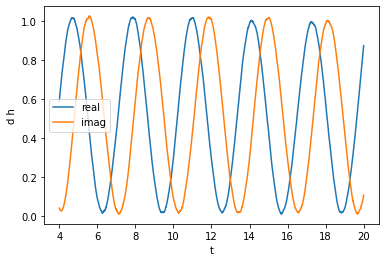

In [12]:
gw_complex = ts.TimeSeries(gw.t, gw.y + 1j * gw_imag.y)

plot(gw_complex.real(), label="real")
plot(gw_complex.imag(), label="imag")
plt.legend()

We can also compute the phase and absolute value. In particular, we will compute the unfolded phase (no wrapping over $2\pi$)

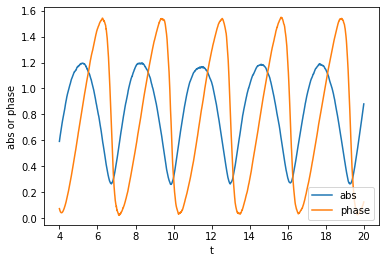

In [13]:
plot(gw_complex.abs(), label='abs')
plot(gw_complex.unfolded_phase(), lab1="abs or phase", label='phase')
plt.legend()

Here, the unfolded phase looks a little bit unusual. This is because we made up the signal.

We can also compute the frequency of the phase, which we can directly smooth.

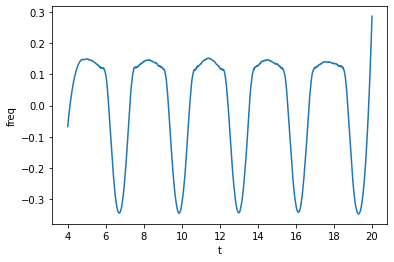

In [14]:
plot(gw_complex.phase_frequency(tsmooth=1.5), lab1="freq")

Next, we will take a Fourier transform. Before, let's pretend that the signal was in geometrized units (as in simulations), and let's make it physical assuming a scale of $M = 1 M_\odot$. For that, use the [unitconv](../unitconv.rst) module. We define a CU object that knows how to convert units.

In [15]:
CU = uc.geom_umass_msun(1) 

# How to convert from geometrized length to physical length?
# Simply multiply times CU.length. Let's check that it is 1.477 km
CU.length  # m

1476.6436994724972

Now we rescale `gw`, assuming that `y` is strain times distance (as usually is). Let's assume a distance of 500 Mpc.

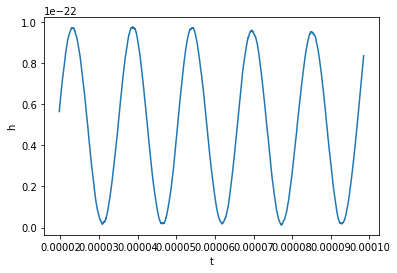

In [16]:
d_Mpc = 500

# inverse = True means from geometrized to physical
gw_physical = gw_complex.time_unit_changed(CU.time, inverse=True)  

gw_physical *= CU.length  # dh -> dh physical
# Now just the strain, since we assume a distance
gw_physical /= (d_Mpc * uc.MEGAPARSEC_SI)

# We have to manually add the redshift
gw_physical.redshifted(luminosity_distance_to_redshift(d_Mpc))

plot(gw_physical.real(), lab1="h")

Okay, now before taking the Fourier transform, we will remove the mean and window our signal. A Tukey window will work.

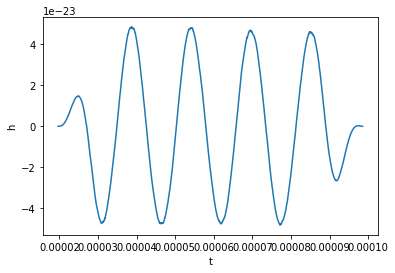

In [17]:
gw_physical.mean_remove()
gw_physical.tukey_window(0.3)
plot(gw_physical.real(), lab1="h")

Finally, we can take the Fourier transform. This is easy to do:

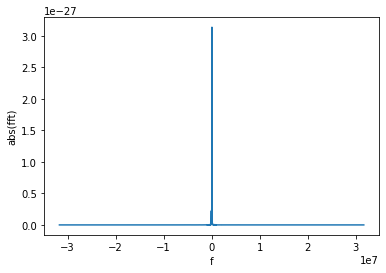

In [18]:
gw_fft = gw_physical.to_FrequencySeries()

# Plotting the amplitude of the Fourier transform
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

The new object is a `FrequencySeries`. It is very similar to a `TimeSeries` and it shares several properties, methods, and features. 

Let's restrict to only positive frequencies close to zero.

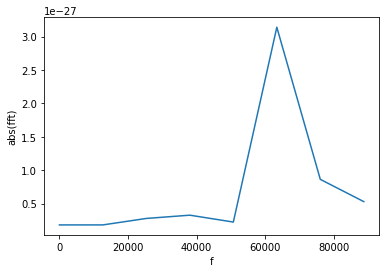

In [19]:
gw_fft.crop(0, 1e5)
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")

We can find the frequency of that peak! For this, we find all the peaks with amplitude larger than 1e-27.

Frequency: 64212.49


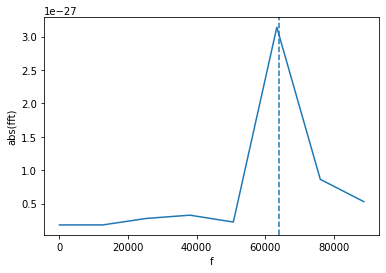

In [20]:
f_peak = gw_fft.peaks_frequencies(1e-27)[0]

print(f"Frequency: {f_peak:.2f}")
plot(gw_fft.abs(), lab1="abs(fft)", lab2="f")
plt.axvline(f_peak, ls = 'dashed')

The line is not on the maximum because we use a quadratic interpolation to find a more accurate location of the peak.

Sometimes, it is useful to ignore some data (or example, when we know that the data is invalid). `Series` objects support _masks_ to mark the points we want to ignore. Most functions work transparently with masks: for example, if you ask for the mean of a `Series`, the masked point will be ignored. Other functions do not support masks (most notably, splines). In that case, it is best to completely remove the masked points and work with clean data.

In [21]:
# Let's mask all the point in the spectrum with value larger than 1e-27

spectrum = gw_fft.abs()

print(f"Maximum without mask {spectrum.max():.3e}")

# Apply mask
spectrum.mask_greater(1e-27)

print(f"Maximum with mask {spectrum.max():.3e}")

print(f"Length with mask {len(spectrum)}")

# Remove points
spectrum.mask_remove()

print(f"Length after having removed the masked points {len(spectrum)}")

Maximum without mask 3.139e-27
Maximum with mask 8.625e-28
Length with mask 8
Length after having removed the masked points 7
